<a href="https://colab.research.google.com/github/RemiJu-collab/CFDS/blob/master/Analysis_colab_Google.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [63]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [64]:
#Install environment
!pip install bt

In [0]:
#  Import librairies and define variables
import os
import pandas as pd
# Principal parameters below
# Select company and data
compTick = 'CRM'
# Folder in which the sentiment file is
drive = "/content/drive/My Drive/Colab Notebooks/"
root_for_sentiments=drive+'CFDS_Tweets_Sentiment'+ os.sep
sufix = '_daily_sentiment_tweets.csv'

# Load the prices from Bloomberg
data_comp = [['ORCL','Oracle'],['MSFT','Microsoft'],['CRM','Salesforce'],
             ['AAPL','Apple'],['PYPL','Paypal'],['MA','Mastercard'],
             ['INTC','Intel Corp'],['CSCO','Cisco Systems'],['NVDA','Nvidia'],['ADBE','Adobe']]
companies = pd.DataFrame(data_comp, columns = ['ticker_root','name'])

#-*- coding: utf-8 -*-
import datetime as dt
import numpy as np
import csv
from pandas import read_csv
from shutil import copyfile

# back testing for trading signals
import bt as bt

# pytorch libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils import data
from torch.utils.data import dataloader

# sklearn libraries
from sklearn import preprocessing
from sklearn import metrics

import matplotlib.pyplot as plt
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['figure.dpi']= 150

%matplotlib inline

if not os.path.exists('./data'): os.makedirs('./data')  # create data directory
if not os.path.exists('./models'): os.makedirs('./models')  # create trained models directory
    
# init deterministic seed
seed_value = 1234
np.random.seed(seed_value) # set numpy seed
torch.manual_seed(seed_value) # set pytorch seed CPU

# set gpu enabled flag
use_gpu = True

# init deterministic GPU seed
torch.cuda.manual_seed(seed_value)
market_data_file = drive + 'CoursBloomberg' + os.sep + 'CFDS_prices_all_calendar_days.csv'
market_data_file_return = drive + 'CoursBloomberg' + os.sep + 'CFDS_prices_all_calendar_days_return.csv'
market_data = read_csv(market_data_file, sep=';', header=0, parse_dates=[0], infer_datetime_format=True)


for index, row in companies.iterrows():
    headername = row['ticker_root'] + '_Return'
    headerticker = row['ticker_root'] + ' US Equity'
    market_data[headername] = market_data[headerticker].pct_change()
    
# Remove first return line
market_data = market_data.drop(0)
market_data.to_csv(market_data_file_return, sep = ";", header=True, index=True)
market_data = market_data.set_index('Date')

# Transform Time-Series Into Sequences


# number of timesteps
sequence_length = 5


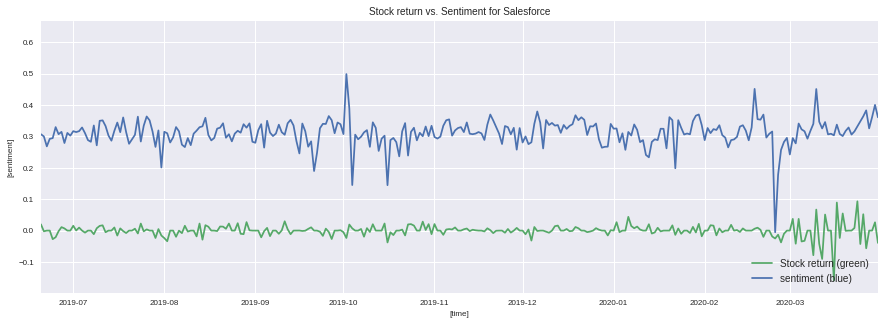

In [66]:
# We can loop over companies
#for company in companies:
#    stock_daily_returns[] = stock_data['RETURN'][1:len(stock_data['RETURN'])]

compName = companies[companies.ticker_root==compTick].name.item()

fields = ['Date','Comp']
sentiment = pd.read_csv(root_for_sentiments + compName + sufix, sep = "|", header=0, usecols=fields, index_col='Date')

c = sentiment['Comp']
#print(c[:5])


# plot the sentiment and the return
plt.rcParams['figure.figsize'] = [15, 5]

fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(pd.to_datetime(market_data.index).values[0:market_data.shape[0],], market_data[compTick + '_Return'], color='C1', label='Stock return (green)')
ax.plot(pd.to_datetime(sentiment.index).values[0:sentiment.shape[0],], sentiment, color='C0', label='sentiment (blue)')

# set y-axis limits
ax.set_xlim(pd.to_datetime(sentiment.index).values[900], pd.to_datetime(sentiment.index).values[1185])

# set plot legend
plt.legend(loc="lower right", numpoints=1, fancybox=True)

plt.title('Stock return vs. Sentiment for '+ compName, fontsize=10)
plt.xlabel('[time]', fontsize=8)
plt.ylabel('[sentiment]', fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)


for i in range(0, c.shape[0] - sequence_length):
    single_sentiment_sequence_data = c[i:i + sequence_length].T

    if i == 0:
        sentiment_sequence_data = np.array(single_sentiment_sequence_data)

    else:
        sentiment_sequence_data  = np.vstack((sentiment_sequence_data , np.array(single_sentiment_sequence_data)))


In [0]:
# Having a look at the correlation
return_comp = market_data[compTick + '_Return']
return_comp = return_comp.drop(pd.to_datetime('2016-12-31'))

np.corrcoef(return_comp, sentiment['Comp'])


array([[1.        , 0.05607367],
       [0.05607367, 1.        ]])

In [0]:
# Prepare sequences for neural network training

# 90% of data will be used to train the model, 10% to test
split_fraction = 0.9
split_row = int(sentiment_sequence_data.shape[0] * split_fraction)

train_sequences = sentiment_sequence_data[:split_row,]
valid_sequences = sentiment_sequence_data[split_row:,]

# Count the number of each population
train_sequences.shape
valid_sequences.shape

# Create inputs and targets of the two sequences
train_sequences_input = torch.from_numpy(train_sequences[:, :-1]).float()
train_sequences_target = torch.from_numpy(train_sequences[:, 1:]).float()
valid_sequences_input = torch.from_numpy(valid_sequences[:, :-1]).float()
valid_sequences_target = torch.from_numpy(valid_sequences[:, 1:]).float()

# case: gpu computing enabled
if use_gpu == True:
  
  # push training sequences onto the the GPUs
  train_sequences_input = train_sequences_input.cuda()
  train_sequences_target = train_sequences_target.cuda()
  # push validation sequences to the GPU
  valid_sequences_input = valid_sequences_input.cuda()
  valid_sequences_target = valid_sequences_target.cuda()
  

In [0]:
# define daily sentiment dataset
class DailySentimentDataset(data.Dataset):

    # define the class constructor
    def __init__(self, sequences, targets):

        # init sequences and corresponding targets
        self.sequences = sequences
        self.targets = targets

    # define the length method 
    def __len__(self):

        # returns the number of samples
        return len(self.targets)

    # define the get item method
    def __getitem__(self, index):

        # determine single sequence and corresponding target
        sequence = self.sequences[index, :]
        target = self.targets[index, :]

        # return sequences and target
        return sequence, target

train_dataset = DailySentimentDataset(train_sequences_input, train_sequences_target)

In [0]:
# Neural network implementation

# implement the LSTMNet network architecture
class LSTMNet(nn.Module):

    # define class constructor
    def __init__(self):

        super(LSTMNet, self).__init__()

        # define lstm nn architecture
        self.lstm1 = nn.LSTMCell(1, 51)  # first lstm layer
        self.lstm2 = nn.LSTMCell(51, 51)  # second lstm layer
        self.linear = nn.Linear(51, 1)  # final linear layer

    # define network forward pass
    def forward(self, input):

        # init predictions
        predictions = []

        # init the lstm hidden states
        h_t = torch.zeros(input.size(0), 51, dtype=torch.float)
        h_t2 = torch.zeros(input.size(0), 51, dtype=torch.float)

        # init the lstm cell states
        c_t = torch.zeros(input.size(0), 51, dtype=torch.float)
        c_t2 = torch.zeros(input.size(0), 51, dtype=torch.float)
        
        # case gpu computing enabled
        if use_gpu == True:
        
          # push the initialized hidden state tensors to gpu
          h_t = h_t.cuda()
          h_t2 = h_t2.cuda()

          # push the initialized hidden cell state tensors to gpu
          c_t = c_t.cuda()
          c_t2 = c_t2.cuda()

        # iterate over distinct time steps
        for i, input_t in enumerate(input.chunk(input.size(1), dim=1)):

            # propagate through time step data
            h_t, c_t = self.lstm1(input_t, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            prediction = self.linear(h_t2)
            
            # collect predictions
            predictions += [prediction]

        # stack predictions
        predictions = torch.stack(predictions, 1).squeeze(2)

        # return predictions
        return predictions

lstm_model = LSTMNet()
# case: gpu computing enabled
if use_gpu == True:
  
  # push model to the GPU
  lstm_model = lstm_model.cuda()

In [0]:
# Preparing loss function
loss_function = nn.MSELoss()
# case: gpu computing enabled
if use_gpu == True:
  # push the loss calculation to the GPU
  loss_function = loss_function.cuda()
learning_rate = 1e-06 # set constant learning rate
optimizer = optim.Adam(lstm_model.parameters(), lr=learning_rate) # define optimization technique

In [71]:
# Specify the training parameters
num_epochs = 20000 # number of training epochs
mini_batch_size = 128 # size of the mini-batches

dataloader = dataloader.DataLoader(train_dataset, batch_size=mini_batch_size, shuffle=False)

# init collection of training epoch losses
train_epoch_losses = []

# set the model in training mode
lstm_model.train()

# init the best loss
best_loss = 100.00

# iterate over epochs
for epoch in range(0, num_epochs):

    # init collection of mini-batch losses
    train_mini_batch_losses = []
            
    # iterate over mini-batches
    for sequence_batch, target_batch in dataloader:

        # predict sequence output
        prediction_batch = lstm_model(sequence_batch)

        # calculate batch loss
        batch_loss = loss_function(prediction_batch, target_batch)

        # run backward gradient calculation
        batch_loss.backward()

        # update network parameters
        optimizer.step()
        
        # collect mini-batch loss
        train_mini_batch_losses.append(batch_loss.data.item())
            
    # determine mean min-batch loss of epoch
    train_epoch_loss = np.mean(train_mini_batch_losses)
    
    # print epoch loss
    now = dt.datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
    print('[LOG {}] epoch: {} train-loss: {}'.format(str(now), str(epoch), str(train_epoch_loss)))
    
    # determine mean min-batch loss of epoch
    train_epoch_losses.append(train_epoch_loss)
        
    # print epoch and save models
    if epoch % 10 == 0 and epoch > 0:
        
        # case: new best model trained
        if train_epoch_loss < best_loss:
                        
            # store new best model
            model_name = compName + '_sentiment_lstm_model_{}.pth'.format(str(epoch))
            torch.save(lstm_model.state_dict(), os.path.join("./models", model_name))
            
            # update best loss
            best_loss = train_epoch_loss
            
            #keep best model
            best_model_path = model_name
            
            # print epoch loss
            now = dt.datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
            print('[LOG {}] epoch: {} new best train-loss: {} found'.format(str(now), str(epoch), str(train_epoch_loss)))

# Save best model in the drive
copyfile(os.path.join("./models", best_model_path),drive + os.path.join("models", best_model_path))

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
[LOG 20200508-13:08:07] epoch: 15001 train-loss: 0.006120530500387152
[LOG 20200508-13:08:07] epoch: 15002 train-loss: 0.006120441610821419
[LOG 20200508-13:08:08] epoch: 15003 train-loss: 0.00612035329039726
[LOG 20200508-13:08:08] epoch: 15004 train-loss: 0.006120265280413959
[LOG 20200508-13:08:08] epoch: 15005 train-loss: 0.0061201776326116585
[LOG 20200508-13:08:08] epoch: 15006 train-loss: 0.006120090243510074
[LOG 20200508-13:08:08] epoch: 15007 train-loss: 0.006120003423550063
[LOG 20200508-13:08:08] epoch: 15008 train-loss: 0.0061199168105506236
[LOG 20200508-13:08:08] epoch: 15009 train-loss: 0.0061198306373424
[LOG 20200508-13:08:08] epoch: 15010 train-loss: 0.006119744929795464
[LOG 20200508-13:08:08] epoch: 15011 train-loss: 0.006119659636169672
[LOG 20200508-13:08:08] epoch: 15012 train-loss: 0.006119574652984738
[LOG 20200508-13:08:08] epoch: 15013 train-loss: 0.006119490213071306
[LOG 20200508

'/content/drive/My Drive/Colab Notebooks/models/Salesforce_sentiment_lstm_model_7850.pth'

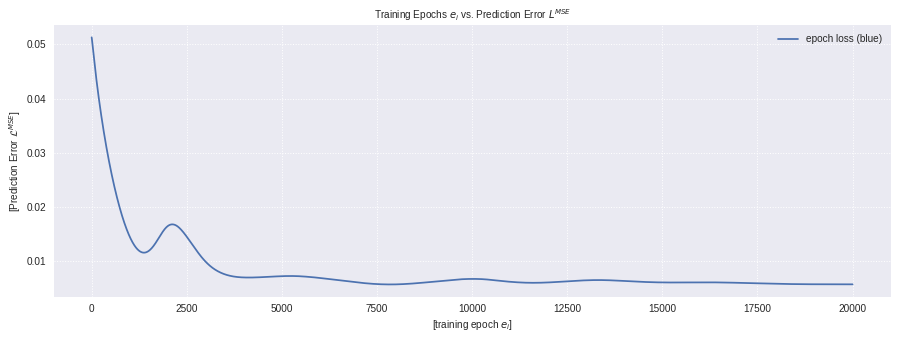

In [72]:
# prepare plot
fig = plt.figure()
ax = fig.add_subplot(111)

# add grid
ax.grid(linestyle='dotted')

# plot the training epochs vs. the epochs' prediction error
ax.plot(np.array(range(1, len(train_epoch_losses)+1)), train_epoch_losses, label='epoch loss (blue)')

# add axis legends
ax.set_xlabel("[training epoch $e_i$]", fontsize=10)
ax.set_ylabel("[Prediction Error $\mathcal{L}^{MSE}$]", fontsize=10)

# set plot legend
plt.legend(loc="upper right", numpoints=1, fancybox=True)

# add plot title
plt.title('Training Epochs $e_i$ vs. Prediction Error $L^{MSE}$', fontsize=10);

(array([-0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7]),
 <a list of 10 Text major ticklabel objects>)

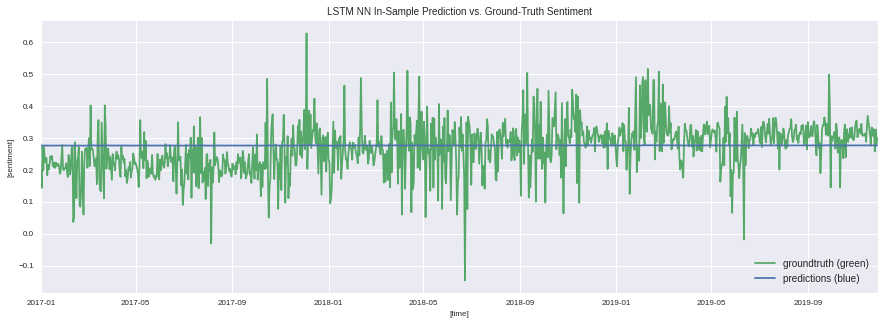

In [0]:
# Evalutation of the model
use_gpu = False

# init the pre-trained model architecture
lstm_model = LSTMNet()

model_name = '/content/drive/My Drive/Colab Notebooks/models/Salesforce_sentiment_lstm_model_7850.pth'#os.path.join("./models", best_model_path)
lstm_model.load_state_dict(torch.load(model_name, map_location='cpu'))

# set model in evaluation mode
lstm_model.eval()

# don't calculate gradients
with torch.no_grad():

    # predict sequence output
    predictions = lstm_model(train_sequences_input.detach().cpu())

    # collect prediction batch results
    predictions_list = predictions.detach().cpu()
    predictions_list = predictions_list.numpy()[:, -1].tolist()

    # collect target batch results
    targets_list = train_sequences_target.cpu()
    targets_list = targets_list.numpy()[:, -1].tolist()

    
# plot the prediction results
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [15, 5]

fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(pd.to_datetime(sentiment.index).values[0:train_sequences.shape[0],], targets_list, color='C1', label='groundtruth (green)')
ax.plot(pd.to_datetime(sentiment.index).values[0:train_sequences.shape[0],], predictions_list, color='C0', label='predictions (blue)')

# set y-axis limits
ax.set_xlim(pd.to_datetime(sentiment.index).values[0], pd.to_datetime(sentiment.index).values[train_sequences.shape[0]])

# set plot legend
plt.legend(loc="lower right", numpoints=1, fancybox=True)

plt.title('LSTM NN In-Sample Prediction vs. Ground-Truth Sentiment', fontsize=10)
plt.xlabel('[time]', fontsize=8)
plt.ylabel('[sentiment]', fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

(array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45]),
 <a list of 10 Text major ticklabel objects>)

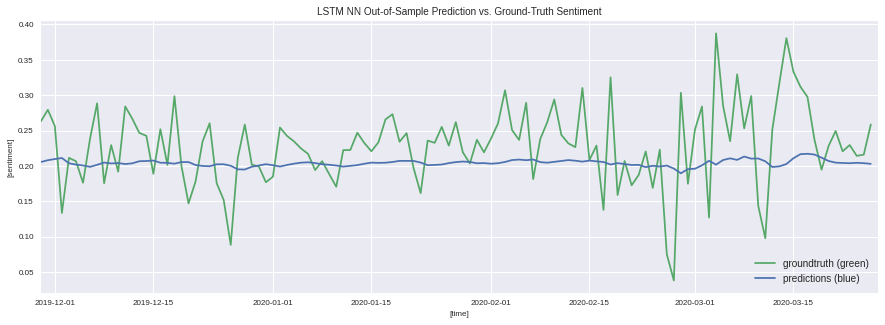

In [0]:
# Out-of-sample evaluation of the model

# don't calculate gradients
with torch.no_grad():

    # predict sequence output
    predictions = lstm_model(valid_sequences_input.detach().cpu())

    # collect prediction batch results
    predictions_list = predictions.detach().cpu()
    predictions_list = predictions_list.numpy()[:, -1].tolist()

    # collect target batch results
    targets_list = valid_sequences_target.detach().cpu()
    targets_list = targets_list.numpy()[:, -1].tolist()

# plot the prediction results
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [15, 5]

fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(pd.to_datetime(sentiment.index).values[train_sequences.shape[0]:train_sequences.shape[0]+valid_sequences.shape[0],], targets_list, color='C1', label='groundtruth (green)')
ax.plot(pd.to_datetime(sentiment.index).values[train_sequences.shape[0]:train_sequences.shape[0]+valid_sequences.shape[0],], predictions_list, color='C0', label='predictions (blue)')

# set y-axis limits
ax.set_xlim(pd.to_datetime(sentiment.index).values[train_sequences.shape[0]], pd.to_datetime(sentiment.index).values[train_sequences.shape[0]+valid_sequences.shape[0]])
#ax.set_ylim(0.0, 1.0)

# set plot legend
plt.legend(loc="lower right", numpoints=1, fancybox=True)

plt.title('LSTM NN Out-of-Sample Prediction vs. Ground-Truth Sentiment', fontsize=10)
plt.xlabel('[time]', fontsize=8)
plt.ylabel('[sentiment]', fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

In [0]:
# Backtest of the model

sentiment_daily_predictions = pd.DataFrame(predictions_list, columns=['PREDICTIONS'])
sentiment_daily_predictions = sentiment_daily_predictions.set_index(pd.to_datetime(sentiment.index).values[train_sequences.shape[0]:train_sequences.shape[0]+valid_sequences.shape[0],])

signal_data = pd.DataFrame(np.where(sentiment_daily_predictions['PREDICTIONS'] > 0.0, 1.0, -1.0), columns=['SIGNAL'])
signal_data = signal_data.set_index(pd.to_datetime(sentiment.index).values[train_sequences.shape[0]:train_sequences.shape[0]+valid_sequences.shape[0],])


stock_market_data = pd.DataFrame(market_data[compTick + ' US Equity'])
stock_market_data = stock_market_data.rename(columns={compTick + ' US Equity': 'PRICE'})
stock_market_data = stock_market_data.set_index(market_data.index)

stock_market_data.head(5)



,PRICE
Date,
2016-12-31,102.95
2017-01-01,102.95
2017-01-02,102.95
2017-01-03,103.48
2017-01-04,104.14


0.04245145866313457


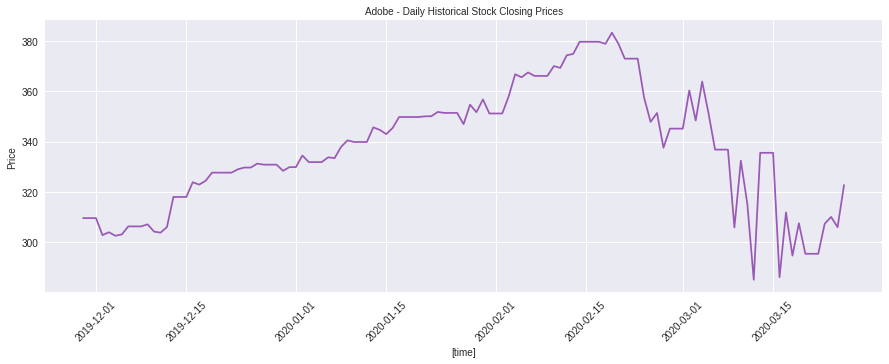

In [0]:
stock_market_data = stock_market_data[stock_market_data.index >= sentiment_daily_predictions.index[0]]
stock_market_data = stock_market_data[stock_market_data.index <= sentiment_daily_predictions.index[-1]]

plt.rcParams['figure.figsize'] = [15, 5]
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(stock_market_data['PRICE'], color='#9b59b6')

for tick in ax.get_xticklabels():
    tick.set_rotation(45)
    
# set axis labels
ax.set_xlabel('[time]', fontsize=10)
ax.set_ylabel('[equity %]', fontsize=10)

for tick in ax.get_xticklabels():
    tick.set_rotation(45)

# set axis labels
ax.set_xlabel('[time]', fontsize=10)
ax.set_ylabel('Price', fontsize=10)

# set plot title
plt.title(compName + ' - Daily Historical Stock Closing Prices', fontsize=10)

# Calculate gain/loss
potential_gain = np.abs(stock_market_data.iloc[0]['PRICE'] - stock_market_data.iloc[-1]['PRICE']) / stock_market_data.iloc[0]['PRICE']
print(potential_gain)

In [0]:
# Prepare backtest
class LSTMStrategy(bt.Algo):
    
    def __init__(self, signals):
        
        # set class signals
        self.signals = signals
        
    def __call__(self, target):
        
        if target.now in self.signals.index[1:]:
            
            # get actual signal
            signal = self.signals.loc[target.now]
            
            # set target weights according to signal
            target.temp['weights'] = dict(PRICE=signal)
            
        # return True since we want to move on to the next timestep
        return True



In [0]:
lstm_strategy = bt.Strategy('lstm', [bt.algos.SelectAll(), LSTMStrategy(signal_data['SIGNAL']), bt.algos.Rebalance()])

backtest_lstm = bt.Backtest(strategy=lstm_strategy, data=stock_market_data, name='stock_lstm_backtest')

signal_data_base = signal_data.copy(deep=True) 
signal_data_base['SIGNAL'] = 1.0

base_strategy = bt.Strategy('base', [bt.algos.SelectAll(), LSTMStrategy(signal_data_base['SIGNAL']), bt.algos.Rebalance()])

backtest_base = bt.Backtest(strategy=base_strategy, data=stock_market_data, name='stock_base_backtest')

In [0]:
backtest_results = bt.run(backtest_lstm, backtest_base)

stock_lstm_backtest
0% [############################# ] 100% | ETA: 00:00:00stock_base_backtest
0% [############################# ] 100% | ETA: 00:00:00

In [0]:
backtest_results.display()

Stat                 stock_lstm_backtest    stock_base_backtest
-------------------  ---------------------  ---------------------
Start                2016-12-30             2016-12-30
End                  2020-03-31             2020-03-31
Risk-free rate       0.00%                  0.00%

Total Return         2.81%                  2.81%
Daily Sharpe         0.12                   0.12
Daily Sortino        0.17                   0.17
CAGR                 0.86%                  0.86%
Max Drawdown         -25.64%                -25.64%
Calmar Ratio         0.03                   0.03

MTD                  -7.79%                 -7.79%
3m                   -3.51%                 -3.51%
6m                   2.81%                  2.81%
YTD                  -3.51%                 -3.51%
1Y                   2.81%                  2.81%
3Y (ann.)            0.93%                  0.93%
5Y (ann.)            0.86%                  0.86%
10Y (ann.)           0.86%                  0.86%
Since 

In [0]:
backtest_lstm_details = backtest_lstm.strategy.data
backtest_lstm_details.columns = ['% EQUITY', 'EQUITY', 'CASH', 'FEES']

backtest_lstm_details.head(10)

,% EQUITY,EQUITY,CASH,FEES
2016-12-30,100.0,1000000.0,1000000.0,0.0
2016-12-31,100.0,1000000.0,1000000.0,0.0
2017-01-01,100.0,1000000.0,1000000.0,0.0
2017-01-02,100.0,1000000.0,1000000.0,0.0
2017-01-03,100.0,1000000.0,1000000.0,0.0
2017-01-04,100.0,1000000.0,1000000.0,0.0
2017-01-05,100.0,1000000.0,1000000.0,0.0
2017-01-06,100.0,1000000.0,1000000.0,0.0
2017-01-07,100.0,1000000.0,1000000.0,0.0
2017-01-08,100.0,1000000.0,1000000.0,0.0


In [0]:
backtest_base_details = backtest_base.strategy.data
backtest_base_details.columns = ['% EQUITY', 'EQUITY', 'CASH', 'FEES']

backtest_base_details.head(10)

,% EQUITY,EQUITY,CASH,FEES
2016-12-30,100.0,1000000.0,1000000.0,0.0
2016-12-31,100.0,1000000.0,1000000.0,0.0
2017-01-01,100.0,1000000.0,1000000.0,0.0
2017-01-02,100.0,1000000.0,1000000.0,0.0
2017-01-03,100.0,1000000.0,1000000.0,0.0
2017-01-04,100.0,1000000.0,1000000.0,0.0
2017-01-05,100.0,1000000.0,1000000.0,0.0
2017-01-06,100.0,1000000.0,1000000.0,0.0
2017-01-07,100.0,1000000.0,1000000.0,0.0
2017-01-08,100.0,1000000.0,1000000.0,0.0


Text(0.5, 1.0, 'Adobe - Backtest % Equity Progression')

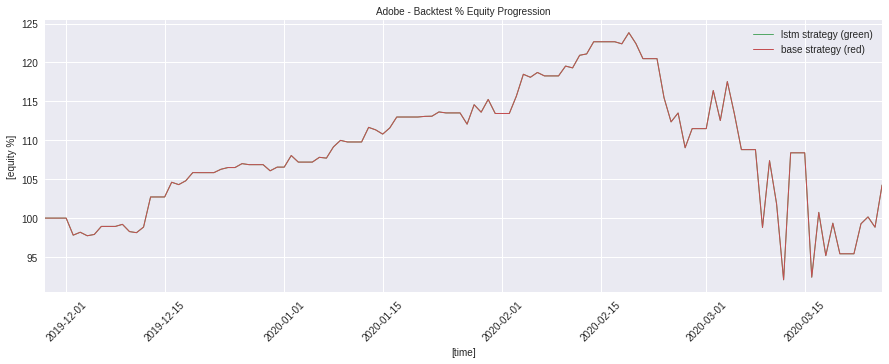

In [0]:
plt.rcParams['figure.figsize'] = [15, 5]
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(backtest_lstm_details['% EQUITY'], color='C1',lw=1.0, label='lstm strategy (green)')
ax.plot(backtest_base_details['% EQUITY'], color='C2',lw=1.0, label='base strategy (red)')

for tick in ax.get_xticklabels():
    tick.set_rotation(45)
    
# set axis labels
ax.set_xlabel('[time]', fontsize=10)
ax.set_xlim(pd.to_datetime(stock_market_data.index).values[train_sequences.shape[0]], pd.to_datetime(stock_market_data.index).values[train_sequences.shape[0]+valid_sequences.shape[0]])
ax.set_ylabel('[equity %]', fontsize=10)

# set plot legend
plt.legend(loc="upper right", numpoints=1, fancybox=True)

# set plot title
plt.title(compName + ' - Backtest % Equity Progression', fontsize=10)